In [1]:
import graspy
import numpy as np
from graspy.simulations import rdpg

In [2]:
n = 100
X1 = np.zeros([n, 1])
deltan = 20
deltax = .1
t = 12

for i in range(n):
    X1[i] = np.random.uniform(0.2, 0.8)

At = np.zeros([t, n, n])
Xt = np.zeros([t, n])
Z = np.r_[deltax*np.ones([deltan//2, 1]), -deltax*np.ones([deltan//2, 1]), np.zeros([n-deltan, 1])]

for i in range(12):
    Xt[i] = np.squeeze(X1)
    if i == 5:
        Xt[i] = np.squeeze(X1+Z)
    elif i == 6: 
        Xt[i] = np.squeeze(X1-Z)
    
    At[i] = rdpg(np.c_[Xt[i], Xt[i]])
    
print(At.shape)
print(Xt.shape)

(12, 100, 100)
(12, 100)


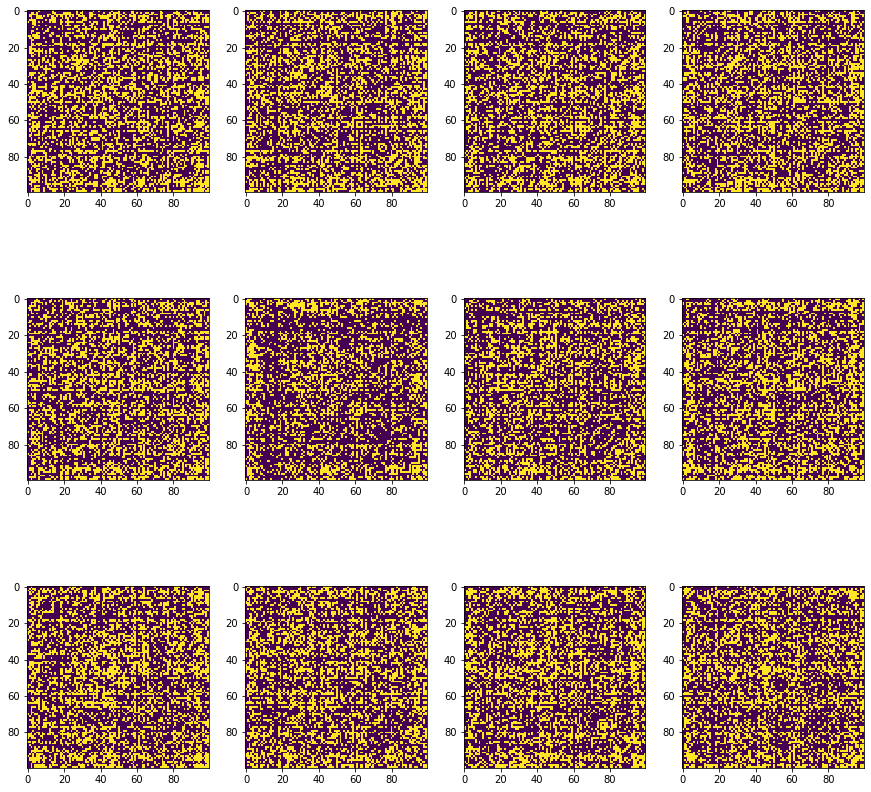

In [3]:
from graspy.plot import heatmap
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))

for i in range(t):
    plt.subplot(3, 4, i+1)
    A = At[i]
    plt.imshow(A)

In [4]:
from rerf.urerf import UnsupervisedRandomForest

In [13]:
clf = UnsupervisedRandomForest(n_estimators=100, max_depth=5, random_state=0)
At_reshaped = At.reshape((t, n*n))
samples = np.diff(At_reshaped, axis=0)
clf.fit(samples)

UnsupervisedRandomForest(feature_combinations='auto', max_depth=5,
                         max_features='auto', min_samples_split='auto',
                         n_estimators=100, n_jobs=None,
                         projection_matrix='RerF', random_state=0)

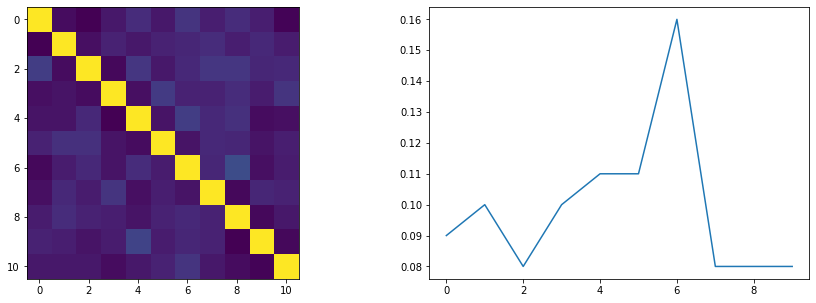

In [14]:
sim_mat = clf.transform()

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(sim_mat)
plt.subplot(1, 2, 2)
plt.plot(sim_mat.diagonal(offset=1))

In [7]:
from sklearn.ensemble import RandomTreesEmbedding

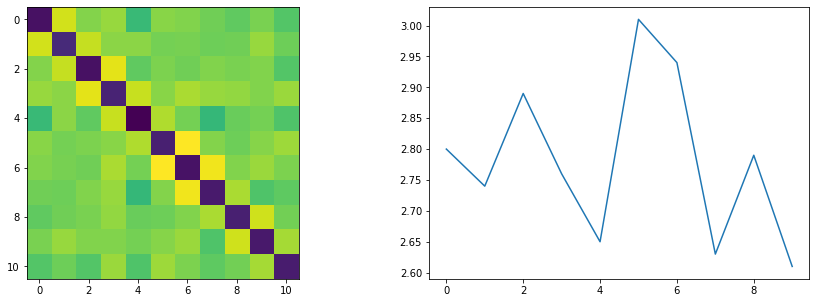

In [11]:
clf = RandomTreesEmbedding(n_estimators=100, max_depth=5, random_state=0)
clf.fit(At_reshaped)
n_estimator = len(clf.estimators_)
path = np.array(clf.decision_path(samples)[0].todense())
d = path.dot(path.T)
d_nca = (d.max() - d) / n_estimator

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(d_nca)
plt.subplot(1, 2, 2)
plt.plot(d_nca.diagonal(offset=1))

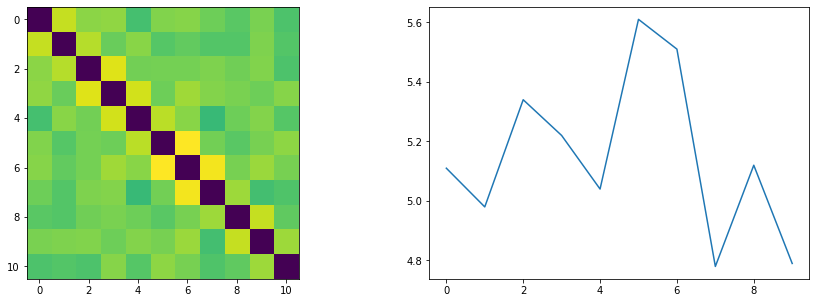

In [10]:
clf = RandomTreesEmbedding(n_estimators=100, max_depth=5, random_state=0)
clf.fit(At_reshaped)
n_sample = len(samples)
n_estimator = len(clf.estimators_)
path = np.array(clf.decision_path(samples)[0].todense())
depth = np.array((path*path).sum(1))
depth = np.tile(depth, (n_sample, 1))
depth = depth+depth.T
d = depth-2*path.dot(path.T)
d_shortest_path = d / n_estimator
# print(d_shortest_path)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(d_shortest_path)
plt.subplot(1, 2, 2)
plt.plot(d_shortest_path.diagonal(offset=1))